# Intro

This notebook provides minimal functionality for applying DMD to noisy climate data. 

The following capabilities are implemented:

* use mask to remove land pixels from training
* window average (window before current time)
* densely sample weekly means around local mins of total ice
* model monthly across years


In [1]:
%load_ext autoreload
%autoreload 2
import dill

import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, BOPDMD, FbDMD, MrDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing import hankel_preprocessing

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.ndimage import gaussian_filter

from tqdm.autonotebook import tqdm, trange

from scipy.signal import fftconvolve

import sys

sys.path.insert(0, '../src/WeatherDMD/')

from WeatherDMD.plot_jupyter import contour_compare, contour_data
from WeatherDMD.data_wrangle import get_days_before, get_test_set, window_mean
from WeatherDMD.dmd_routines import reshape_data2dmd, train_dmd, reshape_Psi2data, eval_dmd

import xarray
import netCDF4 as nc
from netCDF4 import Dataset

/var/folders/98/0b2s056x3lv2gnmph9652hjw0000gq/T/ipykernel_11667/1249405455.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Data


In [3]:
with open('../temp_data/Advection2D_1.pkl', 'rb') as f:
    U, x, y = dill.load(f)


# reshape as 10 "years" of "500" days each
DATA = U.reshape(10, 500, 64, 64)

x.shape, y.shape, U.shape, DATA.shape

((64,), (64,), (5000, 64, 64), (10, 500, 64, 64))

In [3]:
# visualise one year
contour_data(DATA[1])

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=499), IntSlider(value=32, description='f_…

## Train optimised DMD

DMD does not really require batching the data in the deep-AI sense. We simply need to select a training interval and fit DMD. After fitting, DMD model with fitted parameters can be used for prediction on any time interval. 

1. Identify a starting point in time by `year`, `day` 
2. Identify, how many days to train on: `T_train`
3. Select subset of `DATA`, based on the above. Perform window-averaging to de-noise it. 
4. Fit DMD. 
5. Compute DMD predictions from `year`, `day` forward. 

In [4]:
#
year = 3
day = 100

window = 50
T_train = 365*2

# compute windowed mean. Returns T_train snapshots before current time point (not inclusive)
X0_ = get_days_before(DATA, year, day, T_train+window-1)
X0 = window_mean(X0_, window = window, t = None)


X0_.shape, X0.shape

((779, 64, 64), (730, 64, 64))

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=729), IntSlider(value=32, description='f_…

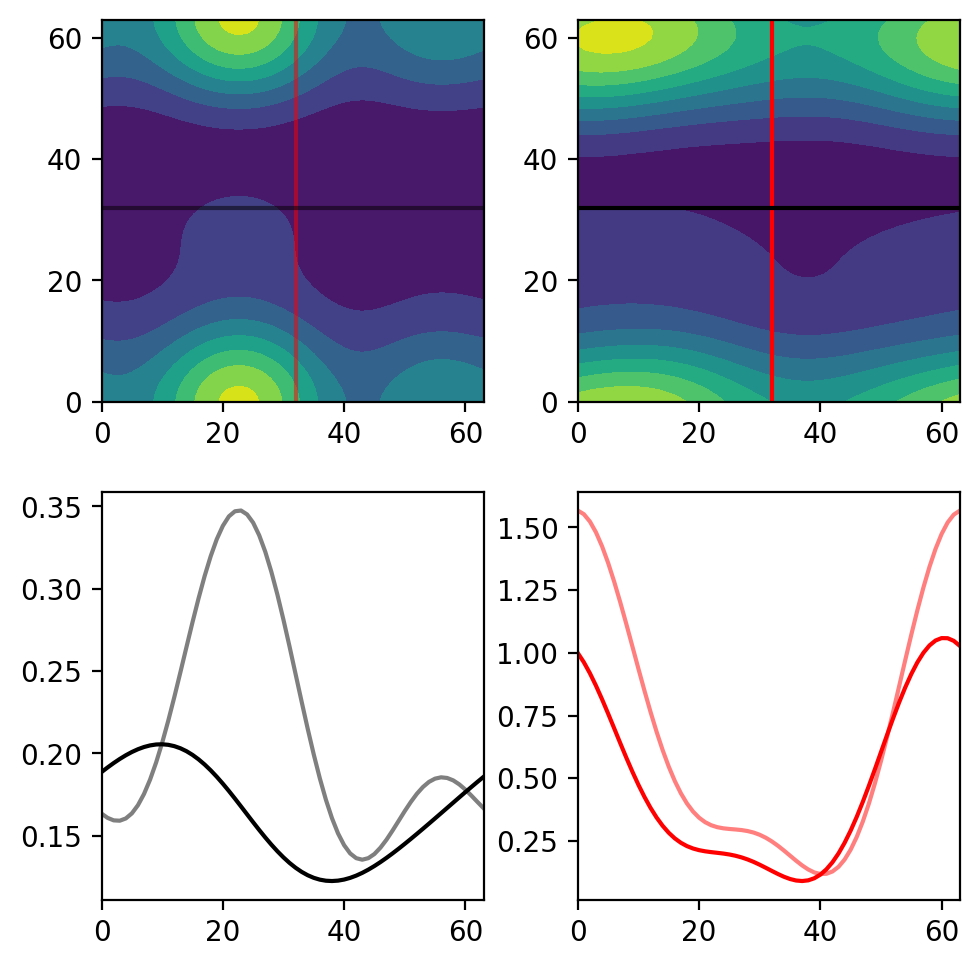

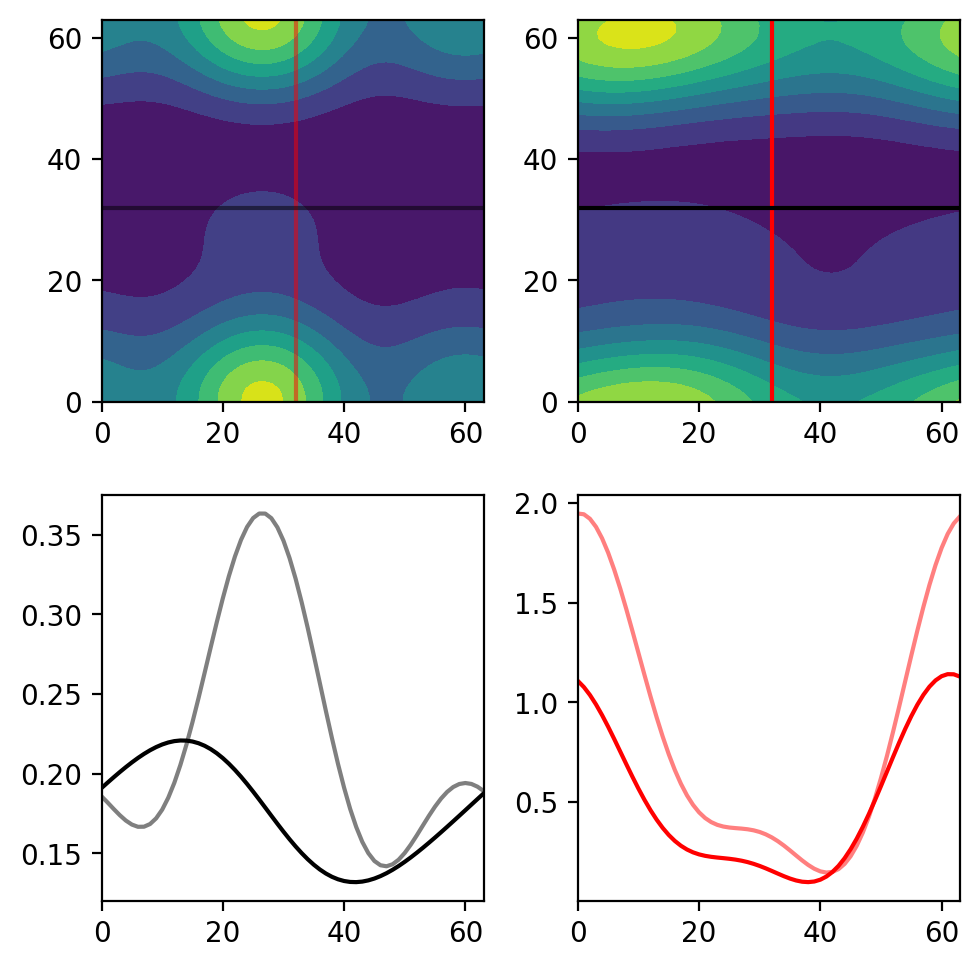

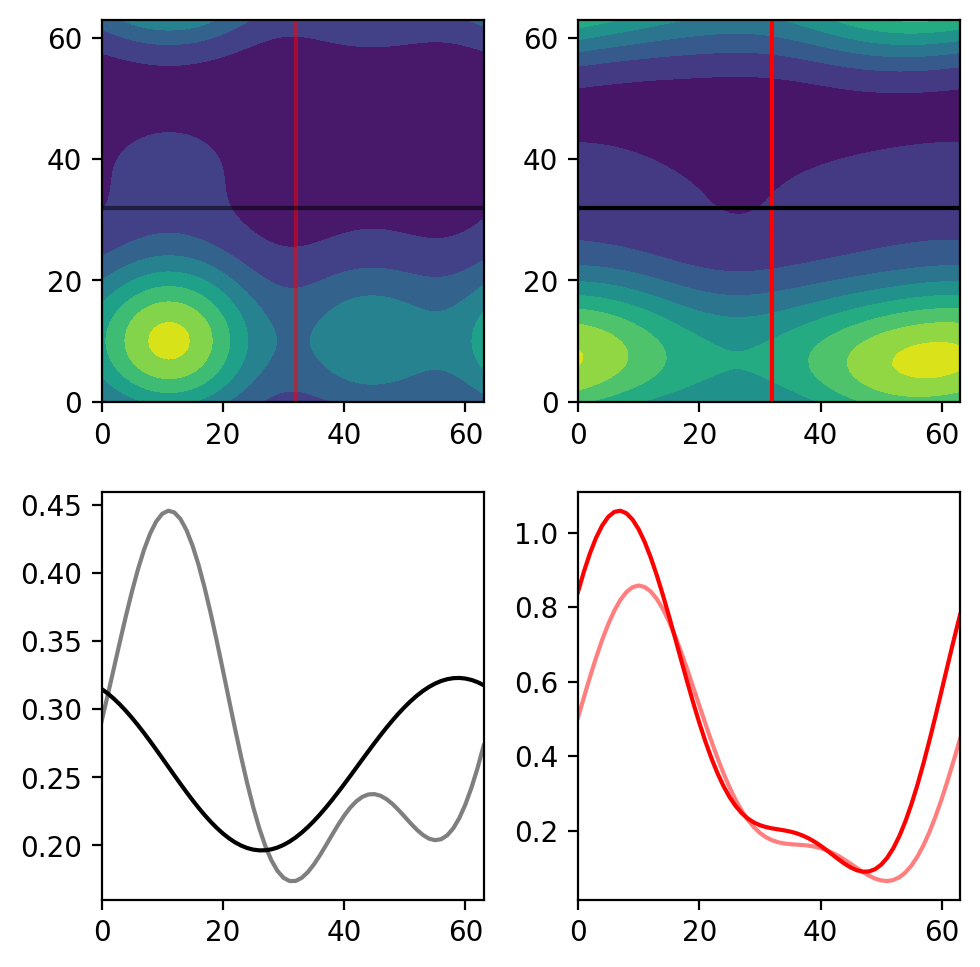

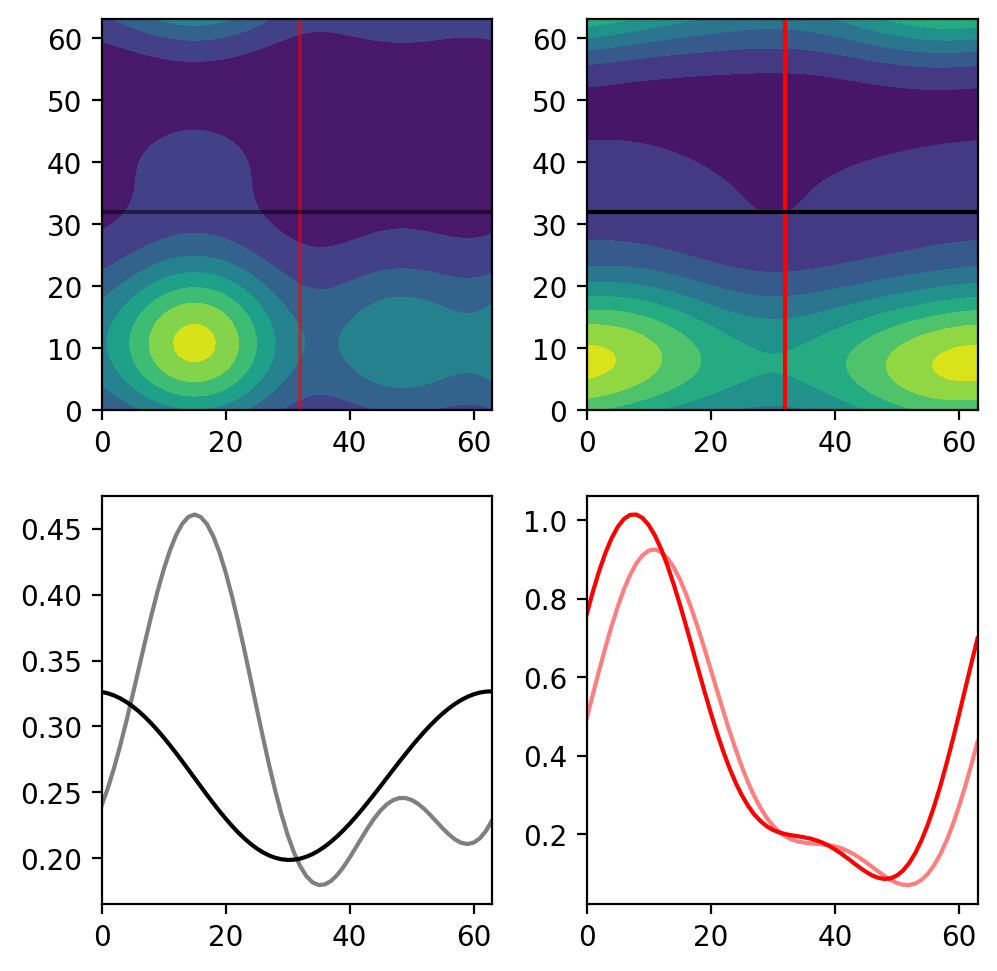

In [10]:
contour_compare(X0_[window-1:], X0)

In [11]:
t = np.arange(-T_train, 0)

# time delay and dmd snapshots
X_delayed, t_delayed, data_shape = reshape_data2dmd(X0, t, time_delay = 2, 
                                                     mask = None,
                                                    isKeepFirstTimes = True)
# train dmd
Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, rank = 15)

Psi = reshape_Psi2data(Psi_, data_shape, mask = None)

/Users/lfrance/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/002_Projects/WeatherDMD/WeatherDMD/.venv/lib/python3.12/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 83363956832.44632. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/Users/lfrance/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/002_Projects/WeatherDMD/WeatherDMD/.venv/lib/python3.12/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


In [7]:
t = np.arange(-T_train, T_train)
true_after = get_test_set(DATA, year, day, window, T_train)
X_true = np.concatenate((X0, true_after), axis = 0)

X_pred = eval_dmd(Lambda, Psi, bn, t)

In [8]:
X_true.shape, X_pred.shape

((1460, 64, 64), (1460, 64, 64))

In [9]:
contour_compare(X_true, X_pred)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=1459), IntSlider(value=32, description='f…

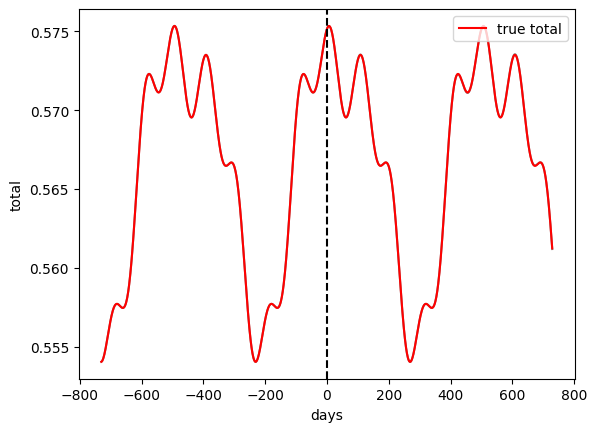

In [10]:
# COMPUTE METRIC OF PREDICTION
Integral_pred = np.trapz(np.trapz(X_pred, x, axis = 2), y, axis = 1)
Integral_true = np.trapz(np.trapz(X_true, x, axis = 2), y, axis = 1)

# plt.plot(t, Integral_pred1.T, color = 'k');
plt.plot(t, Integral_pred.T, color = 'grey');
plt.plot(t, Integral_true, label = 'true total', color = 'r')
plt.axvline(0, linestyle = '--', color = 'k')

plt.ylabel('total')
plt.xlabel('days')

plt.legend(loc = 'upper right')